2022_봄학기_실전기계학습_Competition Guide Code

1. Pretraioned Model 사용금지
2. Personal Data 사용금지
3. Epoch 50회까지 제한
4. Test Data로 Train 금지
5. Model Param 5M이상 금지
6. 최종 제출 모델 파일로 조교가 재현시 비슷한 성능이 나오지 않은 경우
Cheating으로 간주
7. 기타 궁금한 사항들(간단하거나 쉬운 것도 괜찮습니다)은 조교에게 질문주셔요
- Email
- 전자정보대학 325-1 방문

In [1]:
# importing all the libraries we need
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import time
import random 
import pandas as pd
import torch
from torch import nn, cuda, optim
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader,random_split
from PIL import Image
import seaborn as sns
import torch.nn.functional as F
from math import ceil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ./dataset
!unzip /content/drive/MyDrive/Bird.zip -d ./dataset

# Knowing the data 
# data_dir = '/kaggle/input/100-bird-species/175/'
data_dir = '/content/dataset/train'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/train/TASMANIAN HEN/108.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/109.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/110.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/111.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/112.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/113.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/114.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/115.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/116.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/117.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/118.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/119.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/120.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/121.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/122.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/123.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/124.jpg  
  inflating: ./dataset/train/TASMANIAN HEN/125.jpg  
  inflatin

Train 시 로그를 보여주기위해 선언한 Class입니다.

In [3]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Parameter가 5M 미만이 되도록 Custom한 ResNet 코드입니다.
다른 Model을 사용하는 경우 삭제해도 무방합니다.



In [4]:
# Memory-efficient Siwsh using torch.jit.script borrowed from the code in (https://twitter.com/jeremyphoward/status/1188251041835315200)
# Currently use memory-efficient SiLU as default:
USE_MEMORY_EFFICIENT_SiLU = True

if USE_MEMORY_EFFICIENT_SiLU:
    @torch.jit.script
    def silu_fwd(x):
        return x.mul(torch.sigmoid(x))

    @torch.jit.script
    def silu_bwd(x, grad_output):
        x_sigmoid = torch.sigmoid(x)
        return grad_output * (x_sigmoid * (1. + x * (1. - x_sigmoid)))


    class SiLUJitImplementation(torch.autograd.Function):
        @staticmethod
        def forward(ctx, x):
            ctx.save_for_backward(x)
            return silu_fwd(x)

        @staticmethod
        def backward(ctx, grad_output):
            x = ctx.saved_tensors[0]
            return silu_bwd(x, grad_output)


    def silu(x, inplace=False):
        return SiLUJitImplementation.apply(x)

else:
    def silu(x, inplace=False):
        return x.mul_(x.sigmoid()) if inplace else x.mul(x.sigmoid())


class SiLU(nn.Module):
    def __init__(self, inplace=True):
        super(SiLU, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return silu(x, self.inplace)


def ConvBNAct(out, in_channels, channels, kernel=1, stride=1, pad=0,
              num_group=1, active=True, relu6=False):
    out.append(nn.Conv2d(in_channels, channels, kernel,
                         stride, pad, groups=num_group, bias=False))
    out.append(nn.BatchNorm2d(channels))
    if active:
        out.append(nn.ReLU6(inplace=True) if relu6 else nn.ReLU(inplace=True))



def ConvBNSiLU(out, in_channels, channels, kernel=1, stride=1, pad=0, num_group=1):
    out.append(nn.Conv2d(in_channels, channels, kernel,
                         stride, pad, groups=num_group, bias=False))
    out.append(nn.BatchNorm2d(channels))
    out.append(SiLU(inplace=True))


class SE(nn.Module):
    def __init__(self, in_channels, channels, se_ratio=12):
        super(SE, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, channels // se_ratio, kernel_size=1, padding=0),
            nn.BatchNorm2d(channels // se_ratio),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // se_ratio, channels, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y


class LinearBottleneck(nn.Module):
    def __init__(self, in_channels, channels, t, stride, use_se=True, se_ratio=12,
                 **kwargs):
        super(LinearBottleneck, self).__init__(**kwargs)
        self.use_shortcut = stride == 1 and in_channels <= channels
        self.in_channels = in_channels
        self.out_channels = channels

        out = []
        if t != 1:
            dw_channels = in_channels * t
            ConvBNSiLU(out, in_channels=in_channels, channels=dw_channels)
        else:
            dw_channels = in_channels

        ConvBNAct(out, in_channels=dw_channels, channels=dw_channels, kernel=3, stride=stride, pad=1,
                  num_group=dw_channels, active=False)

        if use_se:
            out.append(SE(dw_channels, dw_channels, se_ratio))

        out.append(nn.ReLU6())
        ConvBNAct(out, in_channels=dw_channels, channels=channels, active=False, relu6=True)
        self.out = nn.Sequential(*out)

    def forward(self, x):
        out = self.out(x)
        if self.use_shortcut:
            out[:, 0:self.in_channels] += x

        return out


class ReXNetV1(nn.Module):
    def __init__(self, input_ch=16, final_ch=180, width_mult=1.0, depth_mult=1.0, classes=1000,
                 use_se=True,
                 se_ratio=12,
                 dropout_ratio=0.2,
                 bn_momentum=0.9):
        super(ReXNetV1, self).__init__()

        layers = [1, 2, 2, 3, 3, 5]
        strides = [1, 2, 2, 2, 1, 2]
        use_ses = [False, False, True, True, True, True]

        layers = [ceil(element * depth_mult) for element in layers]
        strides = sum([[element] + [1] * (layers[idx] - 1)
                       for idx, element in enumerate(strides)], [])
        if use_se:
            use_ses = sum([[element] * layers[idx] for idx, element in enumerate(use_ses)], [])
        else:
            use_ses = [False] * sum(layers[:])
        ts = [1] * layers[0] + [6] * sum(layers[1:])

        self.depth = sum(layers[:]) * 3
        stem_channel = 32 / width_mult if width_mult < 1.0 else 32
        inplanes = input_ch / width_mult if width_mult < 1.0 else input_ch

        features = []
        in_channels_group = []
        channels_group = []

        # The following channel configuration is a simple instance to make each layer become an expand layer.
        for i in range(self.depth // 3):
            if i == 0:
                in_channels_group.append(int(round(stem_channel * width_mult)))
                channels_group.append(int(round(inplanes * width_mult)))
            else:
                in_channels_group.append(int(round(inplanes * width_mult)))
                inplanes += final_ch / (self.depth // 3 * 1.0)
                channels_group.append(int(round(inplanes * width_mult)))

        ConvBNSiLU(features, 3, int(round(stem_channel * width_mult)), kernel=3, stride=2, pad=1)

        for block_idx, (in_c, c, t, s, se) in enumerate(zip(in_channels_group, channels_group, ts, strides, use_ses)):
            features.append(LinearBottleneck(in_channels=in_c,
                                             channels=c,
                                             t=t,
                                             stride=s,
                                             use_se=se, se_ratio=se_ratio))

        pen_channels = int(1280 * width_mult)
        ConvBNSiLU(features, c, pen_channels)

        features.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*features)
        self.output = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Conv2d(pen_channels, classes, 1, bias=True))
        
    def extract_features(self, x):
        return self.features[:-1](x)
    
    def forward(self, x):
        x = self.features(x)
        x = self.output(x).flatten(1)
        return x

위에서 정의한 Model을 만들고 Parameter수를 체크한 후
5M 미만인 경우 GPU에서 정상 사용되는지 확인하는 부분입니다.

In [5]:
# loading the model architecture
model = ReXNetV1(classes=400, width_mult = 1.1).cuda()
# Check number of parameters your model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 5000000:
    print('Your model has the number of parameters more than 5 millions..')
    sys.exit()
    
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
model.to(device)
print(device)

Number of parameters: 4796928
cuda:0


Train Data를 불러와 Train set/Validation set으로 구분한 후
각 Data에 Augmentation 기법을 적용하는 부분입니다.

In [8]:
# doing data augmentation 
train_transform = transforms.Compose([transforms.Resize((300,300)),transforms.TrivialAugmentWide(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [9]:
# splitting the data into train/validation/test sets
data = datasets.ImageFolder(data_dir)
train_size = int(len(data))
train_data= data
torch.manual_seed(3334)
print(f'train size: {len(train_data)}')

train_data.transform = train_transform
batch_size = 64
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,pin_memory = True, num_workers = 8)


train size: 58388


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss Function과 Optimizer를 선언하는 부분입니다.
다양한 Loss와 Optimizer를 통해 성능을 올려보세요!

In [10]:
class FocalLossWithSmoothing(nn.Module):
    def __init__(
            self,
            num_classes: int,
            gamma: int = 1,
            lb_smooth: float = 0.1,
            size_average: bool = True,
            ignore_index: int = None,
            alpha: float = None):
        """
        :param gamma:
        :param lb_smooth:
        :param ignore_index:
        :param size_average:
        :param alpha:
        """
        super(FocalLossWithSmoothing, self).__init__()
        self._num_classes = num_classes
        self._gamma = gamma
        self._lb_smooth = lb_smooth
        self._size_average = size_average
        self._ignore_index = ignore_index
        self._log_softmax = nn.LogSoftmax(dim=1)
        self._alpha = alpha

        if self._num_classes <= 1:
            raise ValueError('The number of classes must be 2 or higher')
        if self._gamma < 0:
            raise ValueError('Gamma must be 0 or higher')
        if self._alpha is not None:
            if self._alpha <= 0 or self._alpha >= 1:
                raise ValueError('Alpha must be 0 <= alpha <= 1')

    def forward(self, logits, label):
        """
        :param logits: (batch_size, class, height, width)
        :param label:
        :return:
        """
        logits = logits.float()
        difficulty_level = self._estimate_difficulty_level(logits, label)

        with torch.no_grad():
            label = label.clone().detach()
            if self._ignore_index is not None:
                ignore = label.eq(self._ignore_index)
                label[ignore] = 0
            lb_pos, lb_neg = 1. - self._lb_smooth, self._lb_smooth / (self._num_classes - 1)
            lb_one_hot = torch.empty_like(logits).fill_(
                lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()
        logs = self._log_softmax(logits)
        loss = -torch.sum(difficulty_level * logs * lb_one_hot, dim=1)
        if self._ignore_index is not None:
            loss[ignore] = 0
        return loss.mean()

    def _estimate_difficulty_level(self, logits, label):
        """
        :param logits:
        :param label:
        :return:
        """
        one_hot_key = torch.nn.functional.one_hot(label, num_classes=self._num_classes)
        if len(one_hot_key.shape) == 4:
            one_hot_key = one_hot_key.permute(0, 3, 1, 2)
        if one_hot_key.device != logits.device:
            one_hot_key = one_hot_key.to(logits.device)
        pt = one_hot_key * F.softmax(logits)
        difficulty_level = torch.pow(1 - pt, self._gamma)
        return difficulty_level


criterion = FocalLossWithSmoothing(num_classes = 400)

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.2, momentum=0.9, weight_decay = 1e-4, adaptive = True, rho = 2.0)

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 30)

Train 해주는 함수입니다.

In [11]:
def fit(model,criterion,optimizer,num_epochs=10):
    print_freq = 30
    best_model = model.state_dict()
    best_acc = 0
    train_loss_over_time = []
    train_acc_over_time = []
    start = time.time()
    
    # each epoch has a training and validation phase
    ### our model has only training phase.
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("\n----- epoch: {}, lr: {} -----".format(epoch, optimizer.param_groups[0]["lr"]))
        batch_time = AverageMeter('Time', ':6.3f')
        acc = AverageMeter('Accuracy', ':.4e')
        progress = ProgressMeter(len(train_loader), batch_time, acc, prefix="Epoch: [{}]".format(epoch))

        for phase in ['train','val']:
            
            if phase == 'train':
                data_loader = train_loader
                model.train()                    # set the model to train mode
                end = time.time()

            else:
              continue
            
            running_loss = 0.0
            running_corrects = 0.0
            
            # iterate over the data
            for i,(inputs,labels) in enumerate(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,pred = torch.max(outputs,dim=1)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.first_step(zero_grad = True)
                        criterion(model(inputs), labels).backward()
                        optimizer.second_step(zero_grad = True)

                
                # calculating the loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

                epoch_acc = (running_corrects.double()/len(train_data)).cpu().numpy()
                acc.update(epoch_acc.item(), inputs.size(0))
                
                if phase == 'train':                          
                    batch_time.update(time.time() - end)
                    end = time.time()

                    if i % print_freq == 0:
                        progress.print(i)  

            if phase == 'train':

                epoch_loss = running_loss/len(train_data)
                train_loss_over_time.append(epoch_loss)
                epoch_acc = (running_corrects.double()/len(train_data)).cpu().numpy()
                train_acc_over_time.append(epoch_acc)
                scheduler.step()

            else:
              print('No validation.')
              continue
          
            print(f'{phase} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}')
            
            torch.save(model.state_dict(),'model_latest.pt')
            elapsed_time = time.time() - epoch_start
            print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))

        print('-'*60)
    print('\n') 
    elapsed_time = time.time() - start
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    print(f'best accuracy: {best_acc:.3f}')


    # load best model weights
    model.load_state_dict(best_model)
    loss = {'train':train_loss_over_time}
    acc = {'train':train_acc_over_time}

    return model,loss, acc

In [ ]:
# training the model
# trained for 5 epochs then for 3 epochs then 2
epochs = 30
history, loss, acc = fit(model, criterion, optimizer, num_epochs = epochs)


Test Dataset을 불러오는 부분입니다.


----- epoch: 0, lr: 0.2 -----


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: [0][  0/913]	Time  8.010 ( 8.010)	Accuracy 0.0000e+00 (0.0000e+00)
Epoch: [0][ 30/913]	Time  0.790 ( 1.025)	Accuracy 1.0276e-04 (5.6905e-05)
Epoch: [0][ 60/913]	Time  0.792 ( 0.910)	Accuracy 3.4254e-04 (1.2635e-04)
Epoch: [0][ 90/913]	Time  0.790 ( 0.871)	Accuracy 6.1657e-04 (2.3789e-04)
Epoch: [0][120/913]	Time  0.791 ( 0.852)	Accuracy 8.9059e-04 (3.6660e-04)
Epoch: [0][150/913]	Time  0.790 ( 0.840)	Accuracy 1.1646e-03 (4.9225e-04)
Epoch: [0][180/913]	Time  0.797 ( 0.832)	Accuracy 1.5243e-03 (6.3029e-04)
Epoch: [0][210/913]	Time  0.796 ( 0.826)	Accuracy 2.0038e-03 (7.8994e-04)
Epoch: [0][240/913]	Time  0.804 ( 0.822)	Accuracy 2.3464e-03 (9.6507e-04)
Epoch: [0][270/913]	Time  0.788 ( 0.818)	Accuracy 2.8602e-03 (1.1467e-03)
Epoch: [0][300/913]	Time  0.790 ( 0.816)	Accuracy 3.3055e-03 (1.3419e-03)
Epoch: [0][330/913]	Time  0.790 ( 0.814)	Accuracy 4.0248e-03 (1.5547e-03)
Epoch: [0][360/913]	Time  0.788 ( 0.812)	Accuracy 4.7955e-03 (1.7912e-03)
Epoch: [0][390/913]	Time  0.790 ( 0.81

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: [1][  0/913]	Time  2.684 ( 2.684)	Accuracy 2.0552e-04 (2.0552e-04)
Epoch: [1][ 30/913]	Time  0.790 ( 0.855)	Accuracy 4.3845e-03 (2.4094e-03)
Epoch: [1][ 60/913]	Time  0.790 ( 0.824)	Accuracy 8.4778e-03 (4.4291e-03)
Epoch: [1][ 90/913]	Time  0.791 ( 0.814)	Accuracy 1.3393e-02 (6.5737e-03)
Epoch: [1][120/913]	Time  0.790 ( 0.808)	Accuracy 1.7966e-02 (8.8439e-03)
Epoch: [1][150/913]	Time  0.789 ( 0.805)	Accuracy 2.3464e-02 (1.1215e-02)
Epoch: [1][180/913]	Time  0.791 ( 0.803)	Accuracy 2.8465e-02 (1.3685e-02)
Epoch: [1][210/913]	Time  0.790 ( 0.801)	Accuracy 3.4082e-02 (1.6195e-02)
Epoch: [1][240/913]	Time  0.788 ( 0.800)	Accuracy 4.0351e-02 (1.8829e-02)
Epoch: [1][270/913]	Time  0.801 ( 0.799)	Accuracy 4.6345e-02 (2.1540e-02)
Epoch: [1][300/913]	Time  0.789 ( 0.798)	Accuracy 5.3401e-02 (2.4374e-02)
Epoch: [1][330/913]	Time  0.800 ( 0.798)	Accuracy 6.0115e-02 (2.7316e-02)
Epoch: [1][360/913]	Time  0.788 ( 0.797)	Accuracy 6.7548e-02 (3.0349e-02)
Epoch: [1][390/913]	Time  0.792 ( 0.79

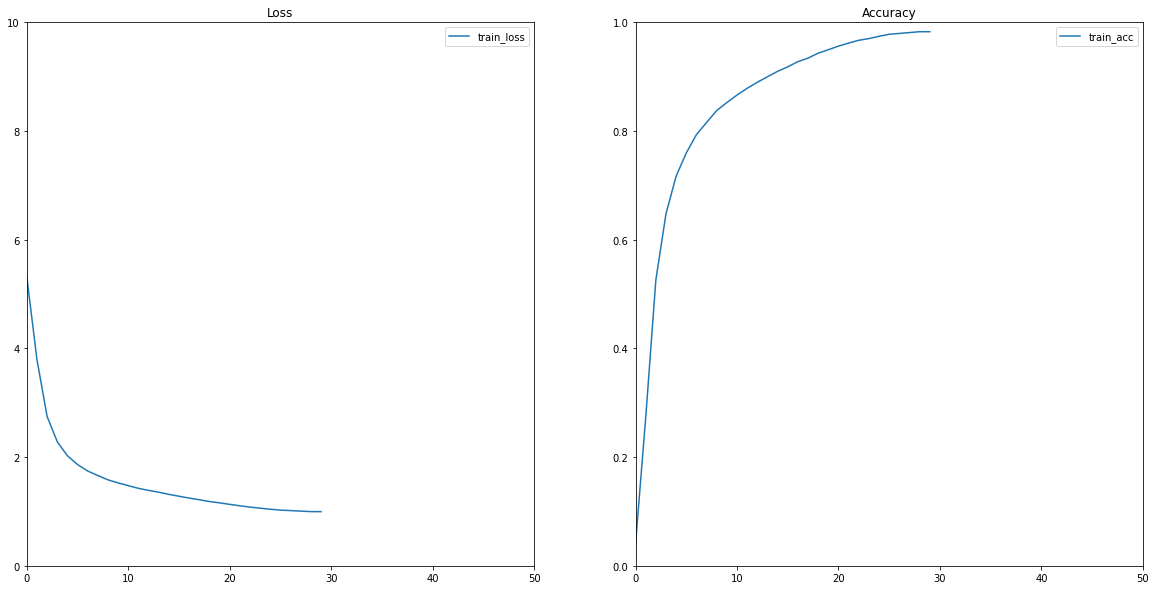

In [12]:
# plotting the loss and accuracy curve for each phase
train_loss = loss['train']
train_acc = acc['train']
print('Only training, No validation')

epochs_range = range(epochs)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.ylim(0,10)
plt.xlim(0,50)
plt.plot(epochs_range, train_loss, label='train_loss')
plt.legend(loc=0)
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc ,label='train_acc')
plt.legend(loc=0)
plt.ylim(0,1)
plt.xlim(0,50)
plt.title('Accuracy')

# TEST Latest Model
seed = 0
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

torch.manual_seed(3334)
test_transform = transforms.Compose([transforms.Resize((300,300)),transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# splitting the data into train/validation/test sets
test_data_dir = '/content/dataset/test'
_data = datasets.ImageFolder(test_data_dir)
test1_size = int(len(_data)*1)
test2_size = int((len(_data)-test1_size))
test_data, test2_data = torch.utils.data.random_split(_data,[test1_size, test2_size])
torch.manual_seed(3334)

print(f'test size: {len(test_data)}')

test_data.dataset.transform = test_transform
batch_size = 64
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)
print(test_loader)

import itertools
# testing how good the model is
def evaluate(model,criterion):
    model.eval()       # setting the model to evaluate mode
    preds = []
    Category = []

    test_model = ReXNetV1(classes=400, width_mult = 1.1).cuda()
    #저장경로는 변경하셔도 됩니다.
    test_model.load_state_dict(torch.load('/content/model_latest.pt'))

    for inputs, label_ in test_loader:
        
        inputs = inputs.to(device)
        labels = label_.to(device)
        # predicting
        with torch.no_grad():

            outputs = test_model(inputs)
            _,pred = torch.max(outputs,dim=1)
            preds.append(pred)

    category = [t.cpu().numpy() for t in preds]
    
    t_category = list(itertools.chain(*category))
   
    Id = list(range(0, len(t_category)))

    prediction = {
      'Id': Id,
      'Category': t_category 
    }

    prediction_df = pd.DataFrame(prediction, columns=['Id','Category'])
    #저장경로는 변경하셔도 됩니다.
    prediction_df.to_csv('/content/drive/MyDrive/0606_prediction_batch_64_epoch_30_latest.csv', index=False)

    print('Done!!')
        
    return preds

# testing the model
predictions = evaluate(model, criterion)